In [1]:
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import time
import glob
from lxml.html import parse
from sphfile import SPHFile
import pydub
import audiosegment
import pandas as pd
from collections import Counter
from bs4 import BeautifulSoup
import sys
import os
from tqdm.notebook import tqdm
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)
sr = 16000
dropout = 0.3
half = False

In [2]:
device = 3
torch.cuda.set_device(device)

In [3]:
class OverlayDataSet(torch.utils.data.Dataset):
    def __init__(self, csv, compute_original = False):
        super().__init__()
        self.overlays = pd.read_csv(csv)
        self.speakers = list(set(self.overlays['first_speaker']).union(set(self.overlays['second_speaker'])))
        self.speakers.sort()
        self.spkr2idx = {spkr:i for i, spkr in enumerate(self.speakers)}
        self.compute_original = compute_original
    def __len__(self):
        return len(self.overlays)
    def __getitem__(self, idx):
        overlay = self.overlays.iloc[idx]
        first_segment = np.load(overlay['first_file'])/(2**15)
        second_segment = np.load(overlay['second_file'])/(2**15)
        #padding to compensate rounding errors
        if len(first_segment)>len(second_segment):
            padding = np.zeros(len(first_segment)-len(second_segment))
            second_segment = np.concatenate((second_segment, padding))
        
        if len(first_segment)<len(second_segment):
            padding = np.zeros(len(second_segment)-len(first_segment))
            first_segment = np.concatenate((first_segment, padding))
        
        
        first_idx  = self.spkr2idx[overlay['first_speaker']]
        second_idx = self.spkr2idx[overlay['second_speaker']]
        target = np.zeros(len(self.speakers))
        target[first_idx] = 1.0
        target[second_idx] = 1.0
        if self.compute_original:
            return self.make_spectrogram(first_segment), self.make_spectrogram(second_segment),\
                self.make_spectrogram(first_segment+second_segment), target
        else:
            return self.make_spectrogram(first_segment+second_segment), target
    def make_spectrogram(self, segment):
        segment = segment[50:-50] # make size 200
        S = librosa.feature.melspectrogram(segment, n_mels = 256, n_fft = 1024, hop_length = 160) # 32 ms window, 10 ms hop
        S_dB = librosa.power_to_db(S).T[None, :, :] # add channel dimension
        return S_dB

trainset = OverlayDataSet('overlay-train.csv', False)
valset = OverlayDataSet('overlay-val.csv', False)
testset = OverlayDataSet('overlay-test.csv', False)
spec3, target = trainset[0]
plt.figure(figsize = (20, 6))
if trainset.compute_original:
    plt.subplot(131)
    plt.imshow(spec1[0].T)
    plt.subplot(132)
    plt.imshow(spec2[0].T)
    plt.subplot(133)
    plt.imshow(spec3[0].T)
print(spec3.max(), spec3.min(), spec3.shape)
print(trainset.speakers)

27.971525 -52.028473 (1, 200, 256)
['andrea_arsenault', 'brian_lamb', 'csp_waj_susan', 'david_brancaccio', 'eddie_mair', 'joie_chen', 'kathleen_kennedy', 'leon_harris', 'linda_wertheimer', 'linden_soles', 'lisa_mullins', 'lou_waters', 'lynn_vaughan', 'mark_mullen', 'natalie_allen', 'noah_adams', 'peter_jennings', 'robert_siegel', 'ted_koppel', 'thalia_assuras']


<Figure size 1440x432 with 0 Axes>

## Maybe try drastically increasing channel number in residual attention stage to see if it overfits

In [4]:
# import torch
import torch.nn as nn
from torch.nn import init
import functools
from torch.autograd import Variable
import numpy as np

class ResidualBlock(nn.Module):
    def __init__(self, input_channels, output_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.stride = stride
        self.bn1 = nn.BatchNorm2d(input_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(input_channels, output_channels, 1, 1, bias = False)
        self.bn2 = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(output_channels, output_channels, 3, stride, padding = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(output_channels, output_channels, 1, 1, bias = False)
        self.conv4 = nn.Conv2d(input_channels, output_channels , 1, stride, bias = False)
        
    def forward(self, x):
        residual = x
        out = self.bn1(x)
        out1 = self.relu(out)
        out = self.conv1(out1)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn3(out)
        out = self.relu(out)
        out = self.conv3(out)
        if (self.input_channels != self.output_channels) or (self.stride !=1 ):
            residual = self.conv4(out1)
        out += residual
        return out

class AttentionModule_stage1(nn.Module):
    # input size is 56*56
    def __init__(self, in_channels, out_channels, size1=(200, 128), size2=(100, 64), size3=(50, 32)):
        super(AttentionModule_stage1, self).__init__()
        self.first_residual_blocks = ResidualBlock(in_channels, out_channels)

        self.trunk_branches = nn.Sequential(
            ResidualBlock(in_channels, out_channels),
            ResidualBlock(in_channels, out_channels)
         )

        self.mpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.softmax1_blocks = ResidualBlock(in_channels, out_channels)

        self.skip1_connection_residual_block = ResidualBlock(in_channels, out_channels)

        self.mpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.softmax2_blocks = ResidualBlock(in_channels, out_channels)

        self.skip2_connection_residual_block = ResidualBlock(in_channels, out_channels)

        self.mpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.softmax3_blocks = nn.Sequential(
            ResidualBlock(in_channels, out_channels),
            ResidualBlock(in_channels, out_channels)
        )

        self.interpolation3 = nn.UpsamplingBilinear2d(size=size3)

        self.softmax4_blocks = ResidualBlock(in_channels, out_channels)

        self.interpolation2 = nn.UpsamplingBilinear2d(size=size2)

        self.softmax5_blocks = ResidualBlock(in_channels, out_channels)

        self.interpolation1 = nn.UpsamplingBilinear2d(size=size1)

        self.softmax6_blocks = nn.Sequential(
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels , kernel_size = 1, stride = 1, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels , kernel_size = 1, stride = 1, bias = False),
            nn.Sigmoid()
        )

        self.last_blocks = ResidualBlock(in_channels, out_channels)

    def forward(self, x):
        #batch_size, nheads, length, n_mels = x.shape
        x = self.first_residual_blocks(x)
        out_trunk = self.trunk_branches(x)
        out_mpool1 = self.mpool1(x) # 100x64
        out_softmax1 = self.softmax1_blocks(out_mpool1)
        out_skip1_connection = self.skip1_connection_residual_block(out_softmax1)
        out_mpool2 = self.mpool2(out_softmax1) # 50x32
        out_softmax2 = self.softmax2_blocks(out_mpool2)
        out_skip2_connection = self.skip2_connection_residual_block(out_softmax2)
        out_mpool3 = self.mpool3(out_softmax2) # 25x16
        out_softmax3 = self.softmax3_blocks(out_mpool3) 
        out_interp3 = self.interpolation3(out_softmax3) + out_softmax2
        out = out_interp3 + out_skip2_connection
        out_softmax4 = self.softmax4_blocks(out)
        out_interp2 = self.interpolation2(out_softmax4) + out_softmax1
        out = out_interp2 + out_skip1_connection
        out_softmax5 = self.softmax5_blocks(out)
        out_interp1 = self.interpolation1(out_softmax5) + out_trunk
        out_softmax6 = self.softmax6_blocks(out_interp1)
        out = (1 + out_softmax6) * out_trunk
        out_last = self.last_blocks(out)
        return out_last

num_heads = 8 # Residual Attention Channels
num_heads_2 = 4 # MHA heads


class OverlayNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.ln = nn.LayerNorm(256)
        self.downsample1 = ResidualBlock(1, num_heads, (1, 2))
        self.res_att = AttentionModule_stage1(num_heads, num_heads)  # batch_size * num_heads * L *128
        self.downsample2 = nn.Sequential(ResidualBlock(num_heads, num_heads//2),
                                        ResidualBlock(num_heads//2, 2),
                                        ResidualBlock(2, 2, (1, 2)))
        self.reshape =  Lambda(lambda x: x.permute((1, 2, 0, 3))) # num_heads, L, batch_size, n_features
        self.lstm = nn.LSTM(64, 32, 2, batch_first = False, bidirectional = True, dropout = dropout) # L * batch_size * n_hidden
        self.mha =  torch.nn.MultiheadAttention(64, num_heads = num_heads_2, dropout=dropout, bias=True, kdim=64, vdim=64) # L * batch * 64
        self.fc1 = nn.Linear(64, 32) # L * batch * 32
        self.average = Lambda(lambda x: x.mean(dim = 0)) # batch * n_hidden
        self.tanh = nn.Tanh() # batch * 32
        #self.norm = Lambda(lambda x: torch.nn.functional.normalize(x, p = 2, dim = 1)) # L2 normalize across n_hidden
        self.fc2 = nn.Linear(32, 20) # batch * 20
        self.softmax = nn.Softmax(1) 
    def forward(self, X):
        X = self.ln(X)
        X = self.downsample1(X)
        #print('first downsample ', X.shape)
        X = self.res_att(X)
        #print('residual attention ', X.shape)
        X = self.downsample2(X)
        #print('second downsample ', X.shape)
        X = self.reshape(X)
        X1, X2 = X[0], X[1]
        X1,_ = self.lstm(X1)
        X2,_ = self.lstm(X1)
        #print('lstm ', X.shape)
        X1,_ = self.mha(X1, X1, X1)
        X2,_ = self.mha(X2, X2, X2)
        #print('mha ', X.shape)
        X1 = self.fc1(X1)
        X2 = self.fc1(X2)
        #print('dense ', X.shape)
        X1 = self.average(X1)
        X2 = self.average(X2)
        #print('mean ', X.shape)
        X1 = self.tanh(X1)
        X2 = self.tanh(X2)
        X1 = self.fc2(X1)
        X2 = self.fc2(X2)
        X1 = self.softmax(X1)
        X2 = self.softmax(X2)
        X = torch.stack([X1,X2], dim=0)
        X,_ = torch.max(X, dim=0)
        return X
    
    
overnet = OverlayNet().cuda(device)
    
# tune hidden layers smaller if overfit
optimizer = torch.optim.Adam(overnet.parameters(), 0.001)

if os.path.exists('models/overnet8.pth'):
    print('load model')
    checkpoint = torch.load('models/overnet8.pth')
    overnet.load_state_dict(checkpoint['model_state_dict'])
    try:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    except:
        print('cannot load optimizer')
    loss = checkpoint['loss']
    if 'bestacc' in checkpoint:
        bestacc = checkpoint['bestacc']
    else:
        bestacc = 0.0
else:
    print('initializing new model')
    bestacc = 0.0
    
if half:
    overnet.half()  # convert to half precision
    for layer in overnet.modules():
        if isinstance(layer, nn.BatchNorm2d):
            layer.float()
            
overnet.train()
'bestacc:', bestacc

load model


('bestacc:', 0.0)

## Also Do metrics on hitting a single person right
## Theoretical justification that when reducing number of channels, neural network could learn to pair similar spectrum representations with each other: only pitch lines that are greater than a certain threshold will pass relu and become postivie. Batchnorm makes this effect stronger. Therefore, when two channels represent spectrums of different people, when they are added the output will be nothing if it doesn't pass the relu threshold

In [5]:
batch_size = 128
def find_max2(tensor):
    array = tensor.cpu().detach().numpy()
    max2 = []
    for row in array:
        max2.append(np.argsort(row)[::-1][:2])
    return np.array(max2)

def compute_corrects(tensor1, tensor2):
    max_1, max_2 = find_max2(tensor1), find_max2(tensor2)
    batch_size = max_1.shape[0]
    batch_corrects = 0
    for i in range(batch_size):
        if Counter(max_1[i])==Counter(max_2[i]):
            batch_corrects+=1
    return batch_corrects

In [7]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory = True, num_workers = 16)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True, pin_memory = True, num_workers = 16)
criterion = torch.nn.BCELoss()

for epoch in range(64):
    running_loss = 0.0
    running_accuracy = 0.0
    for batch_idx, (spec, target) in enumerate(tqdm(trainloader)):
        optimizer.zero_grad()
        spec, target = spec.float(), target.float()
        if half:
            spec, target = spec.half(),target.half()
        spec = spec.cuda(device)
        target = target.cuda(device)

        out = overnet(spec)
        loss = criterion(out, target)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(overnet.parameters(), 0.5)
        optimizer.step()
                
        running_loss += loss.item()
        running_accuracy += compute_corrects(out, target)/batch_size
        if batch_idx % 200 == 199:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f accuracy: %.3f' % 
                  (epoch + 1, batch_idx + 1, running_loss / 200, running_accuracy / 200))
            running_loss = 0.0
            running_accuracy = 0.0
            torch.save({
            'model_state_dict': overnet.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, 'models/overnet8.pth')

        
    with torch.no_grad():
        corrects = 0
        for batch_idx, (spec, target) in enumerate(tqdm(valloader)):
            spec, target = spec.float(), target.float()
            if half:
                spec, target = spec.half(), target.half()
            spec = spec.cuda(device)
            target = target.cuda(device)
            overnet.eval()
            out = overnet(spec) 
            corrects += compute_corrects(out, target)
        print('val acc:', corrects/len(valset))
        if corrects/len(valset) > bestacc:
            bestacc = corrects/len(valset)
            torch.save({
            'model_state_dict': overnet.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'bestacc': bestacc
            }, 'models/best-overnet8.pth')
        overnet.train()
        pass

[1,   200] loss: 0.007 accuracy: 0.985
[1,   400] loss: 0.007 accuracy: 0.986
[1,   600] loss: 0.006 accuracy: 0.987




val acc: 0.9254990925589837


[2,   200] loss: 0.006 accuracy: 0.987
[2,   400] loss: 0.006 accuracy: 0.987
[2,   600] loss: 0.007 accuracy: 0.983




val acc: 0.9252268602540835


[3,   200] loss: 0.005 accuracy: 0.989
[3,   400] loss: 0.006 accuracy: 0.985


KeyboardInterrupt: 

In [6]:
checkpoint = torch.load('models/best-overnet8.pth')
overnet.load_state_dict(checkpoint['model_state_dict'])

testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True, pin_memory = True, num_workers = 16)
        
corrects = 0
for batch_idx, (spec, target) in enumerate(tqdm(testloader)):
    spec, target = spec.float(), target.float()
    if half:
        spec, target = spec.half(), target.half()
    spec = spec.cuda(device)
    target = target.cuda(device)
    overnet.eval()
    out = overnet(spec) 
    corrects += compute_corrects(out, target)
print('test acc:', corrects/len(testset))
overnet.train()
pass

KeyboardInterrupt: 

In [7]:
modulelist2 = list([overnet.downsample1, overnet.res_att, overnet.downsample2])
modulelist1 = list([overnet.downsample1, overnet.res_att])
modulelist0 = list([overnet.downsample1])
extractor2 = nn.Sequential(*modulelist2)
extractor1 = nn.Sequential(*modulelist1)
extractor0 = nn.Sequential(*modulelist0)

Text(0.5, 1.0, 'output 2')

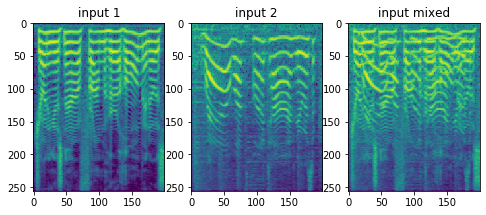

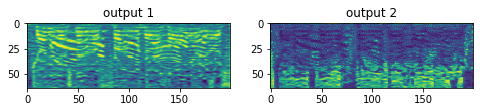

In [20]:
visualset = OverlayDataSet('overlay-test.csv', True)
idx = np.random.randint(len(visualset))
spec1, spec2, spec, target = visualset[idx]
spec = torch.Tensor(spec).cuda(device).float()[None, ...]

out0 = extractor0(spec)[0].detach().cpu().numpy()
out1 = extractor1(spec)[0].detach().cpu().numpy()
out2 = extractor2(spec)[0].detach().cpu().numpy()

#out = out.reshape(-1, out.shape[-1])
# out0 = np.concatenate(out0, axis = 1)
# out1 = np.concatenate(out1, axis = 1)
# out2 = np.concatenate(out2, axis = 1)
plt.figure(figsize = (8, 16))
plt.subplot(131)
plt.imshow(spec1[0].T)
plt.title('input 1')
plt.subplot(132)
plt.imshow(spec2[0].T)
plt.title('input 2')
plt.subplot(133)
plt.imshow(spec[0][0].detach().cpu().numpy().T)
plt.title('input mixed')
# plt.figure(figsize = (32, 8))
# plt.imshow(out0.T)
# plt.figure(figsize = (32, 8))
# plt.imshow(out1.T)
plt.figure(figsize = (8, 16))
plt.subplot(121)
plt.imshow(out2[0].T)
plt.title('output 1')
plt.subplot(122)
plt.imshow(out2[1].T)
plt.title('output 2')